In [1]:
#import necessary libraries 

!pip install tensorflow
!pip install keras 
!pip install opencv-python

import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
import seaborn as sns
from keras.applications.resnet import ResNet50



In [2]:
#Resize images 
SIZE = 256

In [3]:
# Capture training data and labels into respective lists

train_images = []
train_labels = [] 

for directory_path in glob.glob(r"C:\Users\user\Desktop\Nikhil Stuff Dont Open\RESEARCH PROJECT\Multiclassification\dataset\images\train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

elbow
C:\Users\user\Desktop\Nikhil Stuff Dont Open\RESEARCH PROJECT\Multiclassification\dataset\images\train\elbow\non-fracture images (100).png
C:\Users\user\Desktop\Nikhil Stuff Dont Open\RESEARCH PROJECT\Multiclassification\dataset\images\train\elbow\non-fracture images (101).png
C:\Users\user\Desktop\Nikhil Stuff Dont Open\RESEARCH PROJECT\Multiclassification\dataset\images\train\elbow\non-fracture images (102).png
C:\Users\user\Desktop\Nikhil Stuff Dont Open\RESEARCH PROJECT\Multiclassification\dataset\images\train\elbow\non-fracture images (103).png
C:\Users\user\Desktop\Nikhil Stuff Dont Open\RESEARCH PROJECT\Multiclassification\dataset\images\train\elbow\non-fracture images (104).png
C:\Users\user\Desktop\Nikhil Stuff Dont Open\RESEARCH PROJECT\Multiclassification\dataset\images\train\elbow\non-fracture images (105).png
C:\Users\user\Desktop\Nikhil Stuff Dont Open\RESEARCH PROJECT\Multiclassification\dataset\images\train\elbow\non-fracture images (106).png
C:\Users\user\Desktop

In [4]:
#Convert lists to arrays 

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [5]:
# Capture test/validation data and labels into respective lists
test_images = []
test_labels = [] 
for directory_path in glob.glob(r"C:\Users\user\Desktop\Nikhil Stuff Dont Open\RESEARCH PROJECT\Multiclassification\dataset\images\validation/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

In [6]:
#Convert lists to arrays   
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [7]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [8]:
#Split data into test and train datasets 

x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [9]:
# Normalize pixel values to between 0 and 1

x_train, x_test = x_train / 255.0, x_test / 255.0

In [10]:
#One hot encode y values for neural network. 

from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [11]:
#Load model wothout classifier/fully connected layers

resnet_model = ResNet50(weights='imagenet', include_top = False, input_shape=(SIZE, SIZE, 3))

In [12]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights

for layer in resnet_model.layers:
	layer.trainable = False

In [13]:
 #Trainable parameters will be 0
    
resnet_model.summary() 

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
# Using features from convolutional network for RF
feature_extractor=resnet_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [15]:
 #This is our X input to RF
X_for_RF = features

In [16]:
#RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [17]:
# Train the model on training data

RF_model.fit(X_for_RF, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [18]:
#Send test data through same feature extractor process
X_test_feature = resnet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [19]:
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)


Accuracy = 89.58333333333334
kappa score =  0.8785337676126037
              precision    recall  f1-score   support

       elbow       0.73      0.98      0.84        96
      finger       1.00      0.83      0.91       104
     forearm       0.96      0.79      0.87       104
        hand       0.83      0.95      0.89       104
     humerus       0.94      0.98      0.96        96
    shoulder       0.98      0.97      0.98       104
       wrist       0.91      0.79      0.85       112

    accuracy                           0.90       720
   macro avg       0.91      0.90      0.90       720
weighted avg       0.91      0.90      0.90       720



<AxesSubplot:>

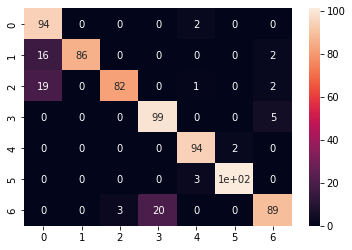

In [20]:


from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,cohen_kappa_score

cm = confusion_matrix(test_labels, prediction_RF)

acc = accuracy_score(test_labels, prediction_RF)*100
print("Accuracy =",acc)
kappa = cohen_kappa_score(test_labels,prediction_RF)
print("kappa score = ",kappa)
print(classification_report(test_labels,prediction_RF))
sns.heatmap(cm, annot=True)





The prediction for this image is:  ['shoulder']
The actual label for this image is:  shoulder


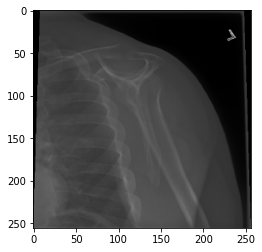

In [22]:
#Check results on a few select images
n=np.random.randint(111, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) 
input_img_feature=resnet_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])